In [2]:
import matplotlib.pyplot as plt

%matplotlib inline
import networkx as nx


# Tutorial 6

## Centrality measures and vulnerablity

In [4]:
# Run this only in Colab environment
# from google.colab import drive
# drive.mount('/content/gdrive')
# path = '/content/gdrive/My Drive/<your_gdrivefolder>/data/'
###############################################################
# for local storage
path = '../data/'
G = nx.read_edgelist(path + 'ia-enron-only/ia-enron-only.edges', nodetype=int)
print(nx.info(G))
# nx.draw(G)

Name: 
Type: Graph
Number of nodes: 143
Number of edges: 623
Average degree:   8.7133


## 1. Visualizing: node size by degree

There are more than the two spatial dimensions to encode information about a data set have.

There is color, shape, size, etc.

Here is a little example on how to encode the degree of a node with the diameter of the circles representing nodes

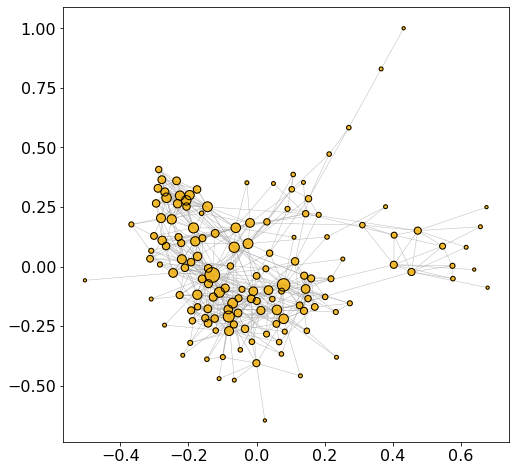

In [6]:
posG = nx.spring_layout(G,weight='weight',iterations=100)

plt.figure(figsize=(8,8))

nx.draw_networkx_edges(G, pos=posG, width=.5,edge_color='#aaaaaa',alpha=.8)

scalef = 5
kpower = 1

l_x = []
l_y = []
l_size = []
for node in G.nodes():
    k = nx.degree(G,node)
    R = scalef*(1+k**kpower)
    l_size.append(R)
    l_x.append(posG[node][0])
    l_y.append(posG[node][1])

plt.scatter(l_x,l_y,s=l_size,c = '#f8b100',zorder=1,alpha=.8)
plt.scatter(l_x,l_y,s=l_size,facecolors='none',edgecolors='k',zorder=2)


ax = plt.gca()

tick_color = 'k'
plt.tick_params(axis='both', which='major', colors=tick_color,labelsize=16)
ax.xaxis.label.set_color(tick_color)
ax.yaxis.label.set_color(tick_color)     




## 2. centrality measures

In the following we will focus on the three most popular centrality measures

o degree

o betweeness

o closeness

Please find out yourself what betweeness and closeness centrality mean.

--> see paper exercise 2

There are more centrality measures which we will ignore for now.

In [7]:
# 
highest_degree_node = max(G.nodes, key=G.degree)
print('highest degree node: %s with k = %s' %(G.degree(highest_degree_node),highest_degree_node))


highest degree node: 42 with k = 105


In [8]:
betweenness = nx.centrality.betweenness_centrality(G)
highest_betweenness_node = max(G.nodes, key=betweenness.get)
print('highest betweeness node: %s with b = %.4f' %(highest_betweenness_node,betweenness[highest_betweenness_node]))


highest betweeness node: 105 with b = 0.1940


In [9]:
closeness = nx.centrality.closeness_centrality(G)
highest_closeness_node = max(G.nodes, key=closeness.get)
print('highest closeness node: %s with b = %.4f' %(highest_closeness_node,closeness[highest_betweenness_node]))



highest closeness node: 105 with b = 0.5000


## 3. robustness

Another way to think about the relative "importance" of nodes in a network is to measure how much it would damage the network structure if particular nodes were to be removed. In real life, node removal might be a person moving away and out of a social network, someone changing jobs and being removed from an email network, internet routers being attacked/overloaded and going down, etc.

Broadly, we consider two types of network damage: random failure and targeted attack. In a random failure, nodes are chosen randomly for removal. In a targeted attack, we will remove nodes based on some criterion, for example, removing nodes in decreasing order of their degree centrality.

### Connected components

In order to measure "damage," we will measure the size of the network's largest connected component, sometimes called *core*. First we observe that `nx.connected_components` is a generator that provides the connected components one at a time, starting with the largest.

In [11]:
components = list(nx.connected_components(G))

the length of this list is the number of connected components:

In [12]:
len(components)

1

### Random failure

Whenever we're going to engage in a distructive process, we want to make a copy of the network graph to attack so that we can easily get back to the original state:

In [13]:
C = G.copy()

To simulate random failure, we randomly choose some node names and remove them from the graph. We can use `random.sample` to remove more than one node at at time. Note that we need to make a `list` of node names from which to randomly sample:

In [14]:
import random

nodes_to_remove = random.sample(list(C.nodes), 2)
C.remove_nodes_from(nodes_to_remove)

The full simulation is going to work like this, beginning from a fresh copy of the network:

1. Measure size of the network core (largest-connected component) as compared to the original network size
2. Select M nodes at random and remove them
3. Repeat until there are less than M nodes

We'll determine M from how many steps we want this process to take. Around 25 steps should be good, so:

In [15]:
number_of_steps = 25
M = G.number_of_nodes() // number_of_steps
M

5

We can then use `range` to generate a sequence of the total number of nodes removed at each step:

In [16]:
num_nodes_removed = range(0, G.number_of_nodes(), M)

The loop is fairly simple. At each step, we need to record the fraction of remaining nodes in the core.

In [21]:
N = G.number_of_nodes()
C = G.copy()
random_attack_core_proportions = []
for nodes_removed in num_nodes_removed:
    # Measure the relative size of the network core
    core = next(nx.connected_components(C))
    core_proportion = len(core) / N
    random_attack_core_proportions.append(core_proportion)
    
    # If there are more than M nodes, select M nodes at random and remove them
    if C.number_of_nodes() > M:
        nodes_to_remove = random.sample(list(C.nodes), M)
        C.remove_nodes_from(nodes_to_remove)

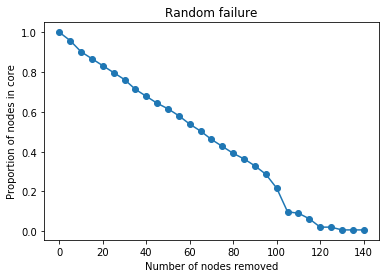

In [22]:
plt.title('Random failure')
plt.xlabel('Number of nodes removed')
plt.ylabel('Proportion of nodes in core')
plt.plot(num_nodes_removed, random_attack_core_proportions, marker='o')

#### Targeted attack

Simulating a targeted attack is similar, except that instead of choosing randomly, we will select the M most central nodes at each step. To accomplish this we want something like the `max` function used earler to get the most central node, but able to get the top M nodes. We can use Python's `sorted` function in a similar way to `max` to first sort the nodes by centrality in descending, or reverse, order. Once sorted by degree, we take the first M nodes in the list:

In [23]:
nodes_sorted_by_degree = sorted(G.nodes, key=G.degree, reverse=True)
top_degree_nodes = nodes_sorted_by_degree[:M]
print(top_degree_nodes)

[105, 17, 95, 48, 132]


In [24]:
betweenness = nx.centrality.betweenness_centrality(G)
highest_betweenness_nodes = sorted(G.nodes, key=betweenness.get, reverse = True)
print(highest_betweenness_nodes[:M])


closeness = nx.centrality.closeness_centrality(G)
highest_closeness_nodes = sorted(G.nodes, key=closeness.get, reverse = True)
print(highest_closeness_nodes[:M])



[105, 17, 48, 91, 32]
[105, 17, 95, 74, 37]


With that in mind, the loop looks similar. Let's put all the pieces together here:

In [25]:
N = G.number_of_nodes()
number_of_steps = 25
M = N // number_of_steps

num_nodes_removed = range(0, N, M)
C = G.copy()
targeted_attack_core_proportions = []
for nodes_removed in num_nodes_removed:
    # Measure the relative size of the network core
    core = next(nx.connected_components(C))
    core_proportion = len(core) / N
    targeted_attack_core_proportions.append(core_proportion)
    
    # If there are more than M nodes, select top M nodes and remove them
    if C.number_of_nodes() > M:
        nodes_sorted_by_degree = sorted(C.nodes, key=C.degree, reverse=True)
        nodes_to_remove = nodes_sorted_by_degree[:M]
        C.remove_nodes_from(nodes_to_remove)

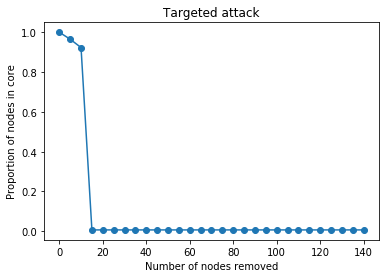

In [26]:
plt.title('Targeted attack')
plt.xlabel('Number of nodes removed')
plt.ylabel('Proportion of nodes in core')
plt.plot(num_nodes_removed, targeted_attack_core_proportions, marker='o')

As we can see, the effect is dramatic. The network is totally disconnected after removing relatively few central nodes in the graph.

Pyplot can plot these curves on the same plot for additional effect:

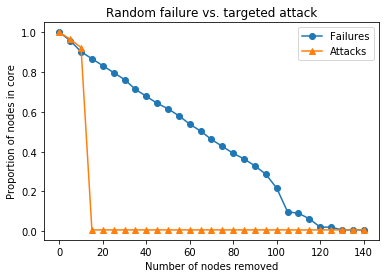

In [27]:
plt.title('Random failure vs. targeted attack')
plt.xlabel('Number of nodes removed')
plt.ylabel('Proportion of nodes in core')
plt.plot(num_nodes_removed, random_attack_core_proportions, marker='o', label='Failures')
plt.plot(num_nodes_removed, targeted_attack_core_proportions, marker='^', label='Attacks')
plt.legend()

# Exercise 1

simulate a targeted attack for

o nodes sorted by betweeness centrality 

o nodes sorted by closeness centrality

o plot the results together with the degree attack to judge which kind of attack leads to the most vulnerable results 

(3 pts)

# Exercise 2

Simulate targeted attacks against the power grid of the American states in the west and find the most vulnerable nodes. (dataset: `powergrid.edgelist.txt`)

Use only degree- and closeness centrality here. (Computing betweeness centrality is too expensive.)

First compare the set of the 5 highest-degree-nodes with the set of the highest-closeness-nodes. What do you notice?

When you iterate through the node removal you don't need to go through the complete node list. Find a reasonable maximal number of nodes to remove.

Also use a meaningful step size M because calculating closeness centrality is computationally expensive, too.

(My loop ran about 10 mins so don't panic if your script is a little busy finishing the task. However, it should also not run much longer. You can control it by setting the step and endpoint of your iteration.)

Plot the results in the same way as above together with the random failure curve.


(6 pts)


# Extra Exercise: Cayley tree

This exercise is optional and may lead to extra points.

Write a function that generates a Cayley tree as defined in paper exercise 3.1

(4 pts)

